In [26]:
import numpy as np
from scipy.optimize import minimize, Bounds
from scipy.optimize import NonlinearConstraint, LinearConstraint

import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
import warnings
warnings.filterwarnings("ignore")

## Model Formulation and Exucution

`xtol` termination condition is satisfied.
Number of iterations: 123, function evaluations: 2450, CG iterations: 294, optimality: 2.44e-04, constraint violation: 0.00e+00, execution time: 0.16 s.
Solution Rates:  [402.83683274 402.8368365  402.83684073 402.83685859 402.8368283
 402.83683533 402.83685017 402.83683355 402.83682995 402.83684776
 402.83685327 402.836848   402.83682169 402.83684825 402.83685251
 402.83685155 402.83684441 402.83684465 402.83684222 354.10000047
 343.89999999 331.19999951 269.99999993 153.19999998]
Sum demands = 9106.3
Sum rates = 9106.300000055366


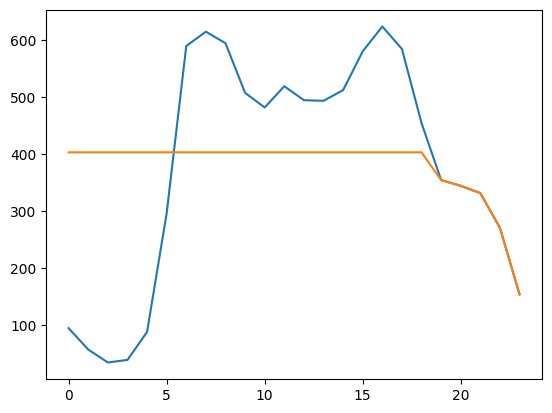

In [28]:
# Model Formulation

R = 2 # Arbitrary constant

real_data = np.array([938, 563, 336, 381, 872, 2957,
                      5896, 6148, 5945, 5073, 4816, 5189,
                     4944, 4933, 5121, 5802, 6239, 5844,
                     4542, 3541, 3439, 3312, 2700, 1532])

real_data_next_day = np.array([890, 540, 411, 404, 889, 2746,
                              4912, 6195, 5351, 4848, 4563, 4872,
                              5135, 5101, 5257, 4762, 5764, 5266,
                              4619, 3660, 3465, 3262, 1688, 384])

test_data = np.array([938, 563, 336, 381, 872, 2957,
                      5896, 6148, 5945, 5073, 4816, 5189,
                     4944, 4933, 5121, 5802, 6239, 5844,
                     4542, 3541, 3439, 3312, 2700, 3300])

# The raw data is hourly traffic volume in a highway. Since I 
# only need to use the distribution to simulate how busy a particular hour of the
# day is, I am multiplying the raw data by a factor (here it is 0.1) to roughly estimate
# the hourly hydorgen demand for a small fuel station.

# h2_demands = test_data * 0.1
h2_demands = real_data * 0.1
# h2_demands = np.concatenate((real_data * 0.1, real_data_next_day * 0.1))

params = h2_demands.shape[0]

X0 = np.full(params, 00)  # Initial guess for X

# Objective function
def objective_fun(X):
    sum = 0
    for q in X:
        sum += ((q**2) * R)
    return sum

def generate_timepoint_h2_level_constraint(j):
    first_part = np.full(j + 1, 1)
    second_part = np.full((params-1) - j, 0)

    return np.concatenate((first_part, second_part))

h2_level_constraints = []

max_tank_size = np.inf
# max_tank_size = 500

for j in range(params):
    # constraints.append(LinearConstraint(generate_timepoint_h2_level_constraint(j), np.sum(B[:j + 1]), np.inf))
    h2_level_constraints.append(
        LinearConstraint(generate_timepoint_h2_level_constraint(j), np.sum(h2_demands[:j + 1]), np.sum(h2_demands[:j + 1]) + max_tank_size)
    )

production_rate_bounds = Bounds(0, np.inf)

solver_log = {'obj_val': [], 'x_val': []}
def callback_fun(x_i, state_i):
    solver_log['obj_val'].append(state_i.fun)
    solver_log['x_val'].append(x_i)

# Model Execution

result = minimize(objective_fun, X0, method = "trust-constr", constraints = h2_level_constraints, bounds = production_rate_bounds,
                  options = {"verbose": 1, "disp": True, "maxiter": 10000}, callback = callback_fun)
                  # options = {"maxiter": 10000}, callback = callback_fun)

if result.success:
    optimized_rates = result.x
    print("Solution Rates: ", optimized_rates)
else:
    print("Solution not found: ", result.message)

t = np.array(range(0, params))

print("Sum demands = " + str(np.sum(h2_demands)))
print("Sum rates = " + str(np.sum(optimized_rates)))

plt.plot(t, h2_demands, label = "main_demand")
plt.plot(t, optimized_rates, label = "Rates")



## Simulation with Results

24


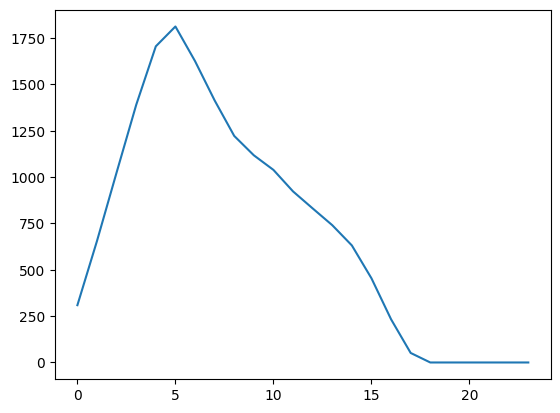

In [29]:
# Simulation with Results

sim_H2_level = 0
h2_level_arr = []
print(result.x.shape[0])

for indx in range(0, result.x.shape[0]):
    sim_H2_level += result.x[indx]
    sim_H2_level -= h2_demands[indx]
    h2_level_arr.append(sim_H2_level)
    # print(sim_H2_level)

plt.plot(t, h2_level_arr, label = "H2 level")

## Model Convergence Analysis

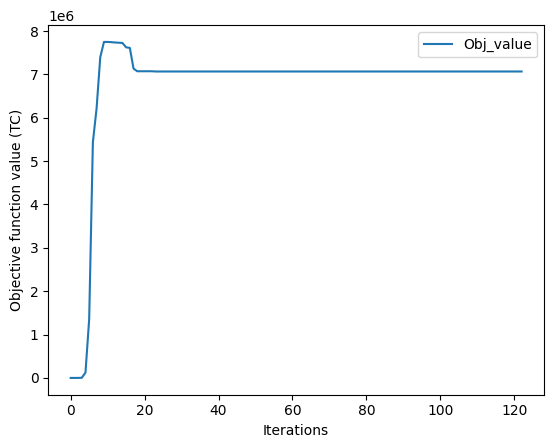

In [30]:
# Model Convergence Analysis

t_obj = range(len(solver_log["obj_val"]))
t_x_val = range(len(solver_log["x_val"]))

# print(solver_log["obj_val"])
# for tt in t_obj:
#     print(tt)
# for i in t_x_val:
#     print(solver_log["x_val"][i])

plt.plot(t_obj, solver_log["obj_val"], label = "Obj_value")
plt.xlabel("Iterations")
plt.ylabel("Objective function value (TC)")
plt.legend()
# plt.savefig("TC_C_500_Initial_00.png", dpi = 300)